# Stack Exchange Expertise Modelling

## Background

Stack Exchange is essentialy just a network of Q&A (Question and Answer) websites. Each website covers a different topic and users are rewarded for their contributions by earning reputation points.

The purpose of this notebook is to try and identify users' expertise and see which users can be considered to be "skilled". Stack Exchange already has an attribute called "reputation" in place but this takes into account many factors such as the quality of questions/answers a user posts.
More information about reputation can be found here https://meta.stackexchange.com/questions/7237/how-does-reputation-work.
However, "reputation" is often very highly related to the amount of time a user has spent registered to the site. Hence, it may be more useful to try and identify a user's "skill" in a slightly different way. This is what we shall try and do.

We shall use the anonymous Stack Exchange data dump for this analysis. The data can be obtained from https://archive.org/details/stackexchange or https://www.dropbox.com/sh/89xbpcjl4oq0j4w/AAA4_cGYM5TqB3dkczIQ0qQJa/StackExchange?dl=0. The data is saved in the .xml format.




## Preliminaries

Before any analysis can be done, we need to ensure that we have Spark installed on our system and are able to use the Spark framework via the Python API (ie, PySpark).

In addition, a number of different libraries need to be imported. These libraries can be seen in the cell below. 

When starting PySpark from the command line on your system, the command below should be used: 

pyspark --packages com.databricks:spark-xml_2.11:0.4.1,graphframes:graphframes:0.3.0-spark2.0-s_2.11

This loads the Spark graphframes package which helps us to store and query the data in the form of GraphFrames.  

## Libraries

In [1]:
# Libaries/Packages to import

from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)

import graphframes
from graphframes import *
import matplotlib.pyplot as plt
%matplotlib inline
from  pyspark.sql.functions import abs
from pyspark.sql import functions as F
from pyspark.sql.functions import lit
from pyspark.sql.types import StringType
from pyspark.sql import Row

from datetime import datetime

import re

sc.setCheckpointDir("file:///tmp") # change where to store if you want to

## Loading the Data

Firstly, we save the data on our local system and then assign the path to the data to the "fpath" variable. 
The load_xml function below takes the .xml data and converts it into an appropriate format for us to use. 

In [2]:
fpath = '/Users/utsavnanda/Documents/GitHub/lectures/project-utsavnanda/StackExchange/'

def load_xml(table_name):
    xml_name = table_name.capitalize()
    table = sqlContext.read.format('com.databricks.spark.xml').options(rowTag=table_name).load(fpath+xml_name+'.xml')
    rdd_table = table.rdd.flatMap(lambda x: x).flatMap(lambda x: x)
    df = sqlContext.createDataFrame(rdd_table, table.schema.fields[0].dataType.elementType)
    df.createOrReplaceTempView(table_name)
    return df

Next, we use the load_xml function to save each file into separate dataframes.

In [3]:
users = load_xml("users")
posts = load_xml("posts")
postlinks = load_xml("postlinks")
comments = load_xml("comments")
tags = load_xml("tags")

The schema of the posts dataframe can be seen below. This provides us with a very useful outline of the dataframe. It tells us the different columns in the dataframe and which data type they each contain. 

In [4]:
posts.printSchema()

root
 |-- _AcceptedAnswerId: long (nullable = true)
 |-- _AnswerCount: long (nullable = true)
 |-- _Body: string (nullable = true)
 |-- _ClosedDate: string (nullable = true)
 |-- _CommentCount: long (nullable = true)
 |-- _CommunityOwnedDate: string (nullable = true)
 |-- _CreationDate: string (nullable = true)
 |-- _FavoriteCount: long (nullable = true)
 |-- _Id: long (nullable = true)
 |-- _LastActivityDate: string (nullable = true)
 |-- _LastEditDate: string (nullable = true)
 |-- _LastEditorDisplayName: string (nullable = true)
 |-- _LastEditorUserId: long (nullable = true)
 |-- _OwnerDisplayName: string (nullable = true)
 |-- _OwnerUserId: long (nullable = true)
 |-- _ParentId: long (nullable = true)
 |-- _PostTypeId: long (nullable = true)
 |-- _Score: long (nullable = true)
 |-- _Tags: string (nullable = true)
 |-- _Title: string (nullable = true)
 |-- _VALUE: string (nullable = true)
 |-- _ViewCount: long (nullable = true)



For illustration purposes, the first post can be seen below.

In [5]:
posts.take(1)

[Row(_AcceptedAnswerId=None, _AnswerCount=1, _Body='<p>I\'ve always been interested in machine learning, but I can\'t figure out one thing about starting out with a simple "Hello World" example - how can I avoid hard-coding behavior?</p>\n\n<p>For example, if I wanted to "teach" a bot how to avoid randomly placed obstacles, I couldn\'t just use relative motion, because the obstacles move around, but I don\'t want to hard code, say, distance, because that ruins the whole point of machine learning.</p>\n\n<p>Obviously, randomly generating code would be impractical, so how could I do this?</p>\n', _ClosedDate='2014-05-14T14:40:25.950', _CommentCount=1, _CommunityOwnedDate=None, _CreationDate='2014-05-13T23:58:30.457', _FavoriteCount=1, _Id=5, _LastActivityDate='2014-05-14T00:36:31.077', _LastEditDate=None, _LastEditorDisplayName=None, _LastEditorUserId=None, _OwnerDisplayName=None, _OwnerUserId=5, _ParentId=None, _PostTypeId=1, _Score=7, _Tags='<machine-learning>', _Title='How can I do si

For our analysis, we will only look at a few of these columns. They include:

* **_Id:** This is the unique id of the respective post.

* **_PostTypeId:** This tells us the type of the respective post. We will only focus on Questions (type 1) and Answers (type 2).

* **_ParentId:** If the post is an Answer, this tells us the unique id of the question this post is answering. If the post is a Question, the _ParentId is null.

* **_OwnerUserId:** This tells us the unique id of the user who created the respective post. 

* **_Score:** Number of upvotes - Number of downvotes for a post.

* **_Tags:** If the post is a Question, this gives us a shapshot of what category the question belongs to. 
 
    

## Analysis

### Creating the GraphFrame

First, we shall look to create a Bipartite Graph. This is a graph with a set of vertices partitioned into two disjoint components (referred as left and right) such that each edge of the graph connects two vertices in different components. The two components will be Questions and Answers, with an edge going from an Answer to the Question it is answering. Hence, a given question can have multiple incoming edges.

As you can see below, to get the question vertices, we've filtered by "_PostTypeId" = 1 and to obtain the answers vertices, we filtered by "_PostTypeId" = 2. The first 5 vertices for each type are displayed. The ids correspond to the unique id each post has. 

In [6]:
questionsVertices = posts.withColumnRenamed("_Id","id").select("id").distinct().filter("_PostTypeId='1'")
answersVertices = posts.withColumnRenamed("_Id","id").select("id").distinct().filter("_PostTypeId='2'")

print("Question Vertices:")
questionsVertices.show(5)

print("Answer Vertices:")
answersVertices.show(5)

Question Vertices:
+----+
|  id|
+----+
| 474|
|5409|
|6721|
|8440|
|9233|
+----+
only showing top 5 rows

Answer Vertices:
+----+
|  id|
+----+
|  26|
|  29|
| 964|
|2453|
|2509|
+----+
only showing top 5 rows



Next, to avoid confusion between the Question vertices and Answer vertices, we add "Q" before each question id and "A" before each answer id. Also, we create "postsEdges" which contains an edge from each Answer to the respective Question it answers. We combine the vertices and edges into a GraphFrame and call it "bipartiteGraph".

In [7]:
questionsVerticesWithType = questionsVertices.rdd.map(lambda r: Row(id="Q"+str(r.id), type="question")).toDF()
answersVerticesWithType = answersVertices.rdd.map(lambda r: Row(id="A"+str(r.id), type="answer")).toDF()

postsEdges = posts.select("_Id","_ParentId").rdd.map(lambda r: Row(src="A"+str(r._Id),dst="Q"+str(r._ParentId))).filter(lambda x: x[0] != "QNone").toDF()

bipartiteVertices = questionsVerticesWithType.unionAll(answersVerticesWithType)
bipartiteEdges = postsEdges

bipartiteGraph = GraphFrame(bipartiteVertices,bipartiteEdges)

Below, we filter the "bipartiteGraph" vertices by type "question" and "answer" and display the first 5 results. In addition, we show the first 5 edges. "dst" stands for the edge destination and "src" stands for the edge source. 

In [8]:
print("The Question Vertices:")
bipartiteGraph.vertices.filter("type='question'").show(5)

print("The Answer Vertices:")
bipartiteGraph.vertices.filter("type='answer'").show(5)

print("The Edges from Answer to Question:")
bipartiteGraph.edges.show(5)

The Question Vertices:
+-----+--------+
|   id|    type|
+-----+--------+
| Q474|question|
|Q5409|question|
|Q6721|question|
|Q8440|question|
|Q9233|question|
+-----+--------+
only showing top 5 rows

The Answer Vertices:
+-----+------+
|   id|  type|
+-----+------+
|  A26|answer|
|  A29|answer|
| A964|answer|
|A2453|answer|
|A2509|answer|
+-----+------+
only showing top 5 rows

The Edges from Answer to Question:
+---+---+
|dst|src|
+---+---+
| Q5| A9|
| Q7|A10|
|Q19|A21|
| Q7|A23|
|Q22|A24|
+---+---+
only showing top 5 rows



Next, we add another couple sets of vertices and edges to the graph. The first set of new vertices are the user ids and an edge will be added from a user id to an answer if that user posted the answer in question. Just like previously, to distinguish between the different sets of vertices, the user id's will be prefixed with "U".

In [9]:
usersVertices = posts.withColumnRenamed("_OwnerUserId","id").select("id").distinct()
usersVerticesWithType = usersVertices.rdd.map(lambda r: Row(id="U"+str(r.id), type="user")).toDF()
usersEdges = posts.select("_Id","_OwnerUserId").rdd.map(lambda r: Row(src="U"+str(r._OwnerUserId),dst="A"+str(r._Id))).toDF()

tripartiteVertices = bipartiteVertices.unionAll(usersVerticesWithType)
tripartiteEdges = bipartiteEdges.unionAll(usersEdges)

tripartiteGraph = GraphFrame(tripartiteVertices,tripartiteEdges)



The second set of new vertices are the scores each post gets. Remember, the "score" is equal to the number of upvotes - the number of downvotes so it is a way of measuring the the quality of a user's answer. An edge will be added from an answer to its respective score.

So in total, the GraphFrame has 4 sets of vertices (Users, Answers, Scores, Questions) and  3 different types of edges (edge from User to Answer, from Answer to Score and from Answer to Question).

The GraphFrame is called quadpartiteGraph.

In [10]:
scoresVertices = posts.withColumnRenamed("_score","score").select("score").filter("_PostTypeId = '2'").distinct()
scoresVerticesWithType = scoresVertices.rdd.map(lambda r: Row(id="S"+str(r.score), type="score")).toDF()
scoresEdges = posts.select("_Id","_score").rdd.map(lambda r: Row(src="A"+str(r._Id),dst="S"+str(r._score))).toDF()

quadpartiteVertices = tripartiteVertices.unionAll(scoresVerticesWithType)
quadpartiteEdges = tripartiteEdges.unionAll(scoresEdges)

quadpartiteGraph = GraphFrame(quadpartiteVertices,quadpartiteEdges)

The next step is to create a dataframe called "all_edges". As the name suggests, this helps us to observe each set of 4 vertices and the 3 edges between them.

The first 5 results are displayed below. 

So for example, you can see that there is an edge from user 21 to answer 46, an edge from answer 46 to question 16 and an edge from question 16 to score 10. Intuitively this means that user 21 posted answer 46 which was answering question 16. This answer got a score of 10 (ie, the upvotes - downvotes = 10). 

In [11]:
all_edges = quadpartiteGraph.find("(user) -[]-> (answer); (answer) -[]-> (question); (answer) -[]-> (score)").where("question.id like '%Q%'").where("score.id like '%S%'")
all_edges.show(5)


+------------+--------------+----------------+-----------+
|        user|        answer|        question|      score|
+------------+--------------+----------------+-----------+
|  [U21,user]|  [A46,answer]|  [Q16,question]|[S10,score]|
|[U4719,user]|[A2315,answer]|[Q1028,question]|[S10,score]|
|[U1224,user]| [A609,answer]| [Q410,question]|[S10,score]|
|[U8878,user]|[A9126,answer]|[Q9038,question]|[S10,score]|
| [U108,user]| [A165,answer]| [Q143,question]|[S10,score]|
+------------+--------------+----------------+-----------+
only showing top 5 rows



### Rating each User's Skill Level

Now that we have created the general GraphFrame and DataFrame of edges, we shall move onto the rating part of the analysis. We need to identify a way of measuring a user's "skill" so that other users can identify if a user's answer is likely to reliable or not. We shall do this by treating each question as a competition and creating a game between each pair of users that answer a given question. This will be discussed more later.

For now we just create a new dataframe called "edges_df" which is the same as the "all_edges" dataframe but with the "U", "A", "Q" and "S" removed from each value.  

In [12]:
edges_df = all_edges.rdd.map(lambda r:Row(user=str(r.user.id[1:]),answer=str(r.answer.id[1:]),question=str(r.question.id[1:]),score=str(r.score.id[1:]))).toDF()
edges_df.show(5)

+------+--------+-----+----+
|answer|question|score|user|
+------+--------+-----+----+
|    46|      16|   10|  21|
|  2315|    1028|   10|4719|
|   609|     410|   10|1224|
|  9126|    9038|   10|8878|
|   165|     143|   10| 108|
+------+--------+-----+----+
only showing top 5 rows



We use the "edges_df" dataframe created above to then create an RDD called "edges_rdd". This contains each question id as keys and the answer id, score and user id as values.

Note: The values for each key are ordered as answer id, score and then user id. 

In [13]:


edges_rdd = edges_df.rdd.map(lambda x:((x[1]),(x[0],x[2],x[3]))).mapValues(list)
edges_rdd.take(5)


[('16', ['46', '10', '21']),
 ('1028', ['2315', '10', '4719']),
 ('410', ['609', '10', '1224']),
 ('9038', ['9126', '10', '8878']),
 ('143', ['165', '10', '108'])]

We then look to create a new data frame called "edges_df_2" which contains each pair of answers for a given question, along with the question id. To do this, we convert the edges_rdd to a dataframe and then convert that to a Spark SQL table. This allows us to peform a Spark SQL query to join each pair of answers for a given question.

The first 5 rows from the table are displayed below. Remember, the 3 elements in the answer list are the post id, score and user id. 

In [14]:
edges_df_2 = sqlContext.createDataFrame(edges_rdd)
sqlContext.registerDataFrameAsTable(edges_df_2, "z")

edges_df_2 = spark.sql("SELECT a._2 AS answer_1 , b._2 AS answer_2, a._1 as question FROM z a JOIN z b ON a._1 = b._1 and a._2[0] < b._2[0]")
edges_df_2.show(5)

+----------------+-----------------+--------+
|        answer_1|         answer_2|question|
+----------------+-----------------+--------+
|  [1176, 4, 924]|   [1184, 0, 890]|    1159|
|  [1176, 4, 924]|[13680, 0, 23802]|    1159|
|  [1184, 0, 890]|[13680, 0, 23802]|    1159|
|[1169, 20, 1279]|   [1176, 4, 924]|    1159|
|[1169, 20, 1279]|   [1184, 0, 890]|    1159|
+----------------+-----------------+--------+
only showing top 5 rows



Now, we add 2 columns to the edges_df_2 dataframe - they are title "winner" and "points".

The "winner" column compares the score for each pair of answers (ie the second entry in the vector) and records the id of the winning user (or puts "draw" if the scores are equal).

The "points" column compares the relative difference in the score for each pair of answers. If the absolute difference is greater than or equal to 5, the winning user gets awarded 5 points. If the absolute difference is greater than or equal to 3 but less than 5, the winning user gets awarded 3 points. If the absolute difference is greate than or equal to 1 but less than 3, the winning user get awarded 1 point. If its a draw, no points are awarded.

There was another scoring method which we considered. This was to award 1 point to each user that wins, award 0.5 points to each user if there is a draw and 0 points otherwise. Then we could sum over each question and divide by the number of questions. This would give a more interpretable result as the score we get could be considered to be a user's probability of beating another user when comparing their 2 answers. However, the reason for not picking this method was that we thought it would be beneficial to reward uers whose answers were much better than their counterpart's, and hence award them 5 points.  

In [15]:
winner=(F.when(F.col("answer_1")[1]>F.col("answer_2")[1], F.col("answer_1")[2]).when(F.col("answer_1")[1]<F.col("answer_2")[1],F.col("answer_2")[2]).otherwise("draw"))
points=(F.when(abs(F.col("answer_1")[1]-F.col("answer_2")[1])>=5, 5).when(abs(F.col("answer_1")[1] - F.col("answer_2")[1]) >= 3,3).when(abs(F.col("answer_1")[1] - F.col("answer_2")[1]) >= 1,1).otherwise(0))

edges_df_2 = edges_df_2.withColumn("winner",winner)
edges_df_2 = edges_df_2.withColumn("points", points)
edges_df_2.show(5)

+----------------+-----------------+--------+------+------+
|        answer_1|         answer_2|question|winner|points|
+----------------+-----------------+--------+------+------+
|  [1176, 4, 924]|   [1184, 0, 890]|    1159|   924|     3|
|  [1176, 4, 924]|[13680, 0, 23802]|    1159|   924|     3|
|  [1184, 0, 890]|[13680, 0, 23802]|    1159|  draw|     0|
|[1169, 20, 1279]|   [1176, 4, 924]|    1159|   924|     5|
|[1169, 20, 1279]|   [1184, 0, 890]|    1159|  1279|     5|
+----------------+-----------------+--------+------+------+
only showing top 5 rows



We can then group the winners and sum their points. The top 10 user ids are displayed below.

We also display the top 10 user ids if we order by the traditional Stack Exchange "reputation" metric. 

In [16]:
top_ten_sum = edges_df_2.select("winner","points").groupBy("winner").sum("points").sort("sum(points)",ascending=False).withColumnRenamed("winner","id").withColumnRenamed("sum(points)","total_score").limit(10)

user_rep = users.select("_id","_reputation").distinct()
post_id = posts.select("_OwnerUserId").withColumnRenamed("_OwnerUserId","_id").distinct()
user_rep = post_id.join(user_rep,"_id").withColumnRenamed("_id","id").withColumnRenamed("_reputation","reputation")
user_rep = user_rep.sort("_reputation",ascending=False).limit(10)

print("Top 10 by Skill:")

top_ten_sum.show()

print("Top 10 by Reputation:")
user_rep.show()

Top 10 by Skill:
+----+-----------+
|  id|total_score|
+----+-----------+
|2452|        299|
| 381|        231|
| 434|        192|
| 843|        178|
| 924|        165|
|  97|        158|
|  84|        144|
|  59|        122|
|  21|        114|
| 514|        109|
+----+-----------+

Top 10 by Reputation:
+-----+----------+
|   id|reputation|
+-----+----------+
|  381|      5709|
| 2452|      4923|
|  836|      4916|
|11097|      3375|
| 8820|      3156|
|   21|      3154|
|  924|      3044|
| 9420|      3022|
|  108|      2887|
|14904|      2880|
+-----+----------+



Below, we have a couple of bar plots which visualise the findings from above. Notice that four users present in the top 10 "skill" table are also present in the top 10 "reputation" table. These are: 2452, 381, 924 and 21.

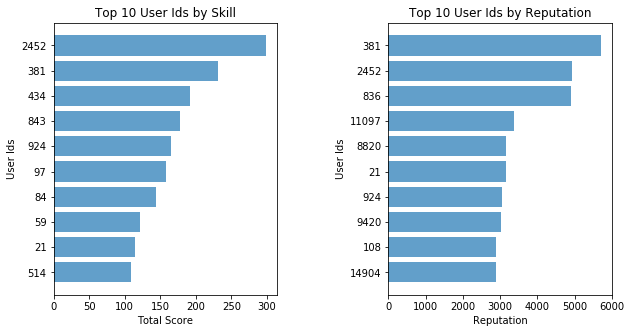

In [17]:
top_10_1 = top_ten_sum.collect()
top_10_2 = user_rep.collect()

fig, ax = plt.subplots(ncols = 2, nrows = 1, figsize=(10,5))

ax[0].barh(range(len(top_10_1)),[t.total_score for t in top_10_1], alpha=0.7)
ax[0].set_yticks(range(len(top_10_1)))
ax[0].set_yticklabels([t.id for t in top_10_1])
ax[0].invert_yaxis()
ax[0].set_title("Top 10 User Ids by Skill")
ax[0].set_xlabel("Total Score")
ax[0].set_ylabel("User Ids")


ax[1].barh(range(len(top_10_2)),[t.reputation for t in top_10_2], alpha=0.7)
ax[1].set_yticks(range(len(top_10_2)))
ax[1].set_yticklabels([t.id for t in top_10_2])
ax[1].invert_yaxis()
ax[1].set_title("Top 10 User Ids by Reputation")
ax[1].set_xlabel("Reputation")
ax[1].set_ylabel("User Ids")

fig.subplots_adjust(wspace=0.5)

plt.show()

Arguably, it may be thought that summing each user's score over all the questions may give more weight to users who have answered many questions or who have answered questions which have a number of answers. 

Below, we have calculated the average score for each user. Here, their total points is divided by the total number of pairs of answers over all the questions they answer. 

However, as we can see, a lot of users have an average score of 5. This is because they, either have answered very few questions, or have answered questions which have very few answers. Hence, they would have won all of their matches against other users. So this may be not a very reliable way of measuring a user's skill. For this reason, we decided to stick to the method of summing the points and using that as the skill measure for the moment. 

In [18]:
top_ten_avg = edges_df_2.select("winner","points").groupBy("winner").avg("points").sort("avg(points)",ascending=False).withColumnRenamed("winner","id").withColumnRenamed("avg(points)","average_score").limit(10)

top_ten_avg.show()

+-----+-------------+
|   id|average_score|
+-----+-------------+
| 9766|          5.0|
|23521|          5.0|
| 5179|          5.0|
| 4730|          5.0|
|  154|          5.0|
|16267|          5.0|
| 4719|          5.0|
|18637|          5.0|
|  132|          5.0|
| 6385|          5.0|
+-----+-------------+



### Adding Tags to GraphFrame

The final step of our analysis is to add tags to the graphframe. Each question on StackExchange can be assigned a tag which gives users more information about what topic the question is related to.

We follow a similar procedure to what we did previously when constructing the quadpartiteGraph. 

In [19]:
tagsVerticesWithType = tagsVertices = posts.select("_Tags").distinct().rdd.map(lambda r: Row(id="TAG"+str(r._Tags), type="tag")).toDF()
tags_regex = re.compile(r"<\w*>")
tagsEdges = posts.select("_Tags","_Id").dropna().rdd.flatMap(lambda r: [Row(src="Q"+str(r._Id),dst="TAG"+str(tag)) for tag in tags_regex.findall(r._Tags)]).toDF()

pentpartiteVertices = quadpartiteVertices.unionAll(tagsVerticesWithType)
pentpartiteEdges = quadpartiteEdges.unionAll(tagsEdges)

pentpartiteGraph = GraphFrame(pentpartiteVertices,pentpartiteEdges)

The edges of the pentpartiteGraph can be seen below. There is now an additional vertex (tag) and an additional set of edges which go from the question to tag. 

In [20]:
edges = pentpartiteGraph.find("(user) -[]-> (answer); (answer) -[]-> (question); (answer) -[]-> (score); (question) -[]-> (tag)").where("question.id like'%Q%'").where("score.id like '%S%'").where("tag.id like '%<%'" )
edges.show(5)

+-------------+---------------+-----------------+----------+--------------+
|         user|         answer|         question|     score|           tag|
+-------------+---------------+-----------------+----------+--------------+
|  [U381,user]|[A14022,answer]|[Q14021,question]|[S8,score]|[TAG<csv>,tag]|
| [U8517,user]|[A14024,answer]|[Q14021,question]|[S0,score]|[TAG<csv>,tag]|
|[U24225,user]|[A14023,answer]|[Q14021,question]|[S1,score]|[TAG<csv>,tag]|
|[U11097,user]| [A8175,answer]| [Q8173,question]|[S1,score]|[TAG<csv>,tag]|
|  [U201,user]| [A6729,answer]| [Q6727,question]|[S0,score]|[TAG<csv>,tag]|
+-------------+---------------+-----------------+----------+--------------+
only showing top 5 rows



The next step is to remove the letter prefixes and then we create an RDD with question id as the key. The values are put in the following order: answer id, score, tag and user id.

In [21]:
edges_df_3 = edges.rdd.map(lambda r:Row(user=str(r.user.id[1:]),answer=str(r.answer.id[1:]),question=str(r.question.id[1:]),score=str(r.score.id[1:]),tag=str(r.tag.id[3:]))).toDF()
edges_rdd_2 = edges_df_3.rdd.map(lambda x:((x[1]),(x[0],x[2],x[3],x[4]))).mapValues(list)
edges_rdd_2.take(5)

[('14021', ['14022', '8', '<csv>', '381']),
 ('14021', ['14024', '0', '<csv>', '8517']),
 ('14021', ['14023', '1', '<csv>', '24225']),
 ('8173', ['8175', '1', '<csv>', '11097']),
 ('6727', ['6729', '0', '<csv>', '201'])]

We then convert the RDD to an SQL table and get each pair of answers for each question, along with the relevant question tag. 

The previous steps to calculate each user's score and obtain the right format for the dataframe are repeated here.

In [23]:
edges_df_4 = sqlContext.createDataFrame(edges_rdd_2)
sqlContext.registerDataFrameAsTable(edges_df_4, "z2")

edges_df_4 = spark.sql("SELECT a._2 AS answer_1 , b._2 AS answer_2, a._1 as question, a._2[2] as tag FROM z2 a JOIN z2 b ON a._1 = b._1 and a._2[0] < b._2[0]")

winner=(F.when(F.col("answer_1")[1]>F.col("answer_2")[1], F.col("answer_1")[3]).when(F.col("answer_1")[1]<F.col("answer_2")[1],F.col("answer_2")[3]).otherwise("draw"))
points=(F.when(abs(F.col("answer_1")[1]-F.col("answer_2")[1])>=5, 5).when(abs(F.col("answer_1")[1] - F.col("answer_2")[1]) >= 3,3).when(abs(F.col("answer_1")[1] - F.col("answer_2")[1]) >= 1,1).otherwise(0))

edges_df_4 = edges_df_4.withColumn("winner",winner)
edges_df_4 = edges_df_4.withColumn("points", points)
edges_df_4.show(5)

+--------------------+--------------------+--------+---------+------+------+
|            answer_1|            answer_2|question|      tag|winner|points|
+--------------------+--------------------+--------+---------+------+------+
|[1176, 4, <bigdat...|[1184, 0, <bigdat...|    1159|<bigdata>|   924|     3|
|[1176, 4, <bigdat...|[13680, 0, <bigda...|    1159|<bigdata>|   924|     3|
|[1184, 0, <bigdat...|[13680, 0, <bigda...|    1159|<bigdata>|  draw|     0|
|[1169, 20, <bigda...|[1176, 4, <bigdat...|    1159|<bigdata>|   924|     5|
|[1169, 20, <bigda...|[1184, 0, <bigdat...|    1159|<bigdata>|  1279|     5|
+--------------------+--------------------+--------+---------+------+------+
only showing top 5 rows



As we are applying Big Data techniques, let's observe which user obtained the highest score within this category. The top 10 users within the "Big Data" tag are displayed below. We can see that user 2452 clearly has the highest score so he/she can been seen to be the Stack Exchange expert within this field.

In [24]:
top_ten = edges_df_4.select("winner","points","tag").where("tag = '<bigdata>'").groupBy("winner").sum("points").sort("sum(points)",ascending=False).withColumnRenamed("winner","id").withColumnRenamed("sum(points)","total").limit(10)

print("Top 10 by Skill (Big Data Tag):")

top_ten.show()


Top 10 by Skill (Big Data Tag):
+----+-----+
|  id|total|
+----+-----+
|2452|  106|
| 843|   66|
|8843|   66|
|2433|   64|
|  59|   59|
| 227|   58|
|3430|   56|
|  26|   50|
| 462|   50|
| 381|   49|
+----+-----+



## Conclusion

To conclude, we created a method to try and evaluate a user's skill level based on the answers they have contributed to Stack Exchange in a way that the regular "reputation" system doesn't. The "reputaton" based system takes into account a vast array of factors and doesn't just focus on a user's answers. However, the method we have created here focuses solely on the answers. As we have seen, user 2452 seems to be the most "skilled" user overall and he/she is also the most "skilled" when it comes to answering questions withing the "Big Data" category. Furthermore, there seems to be some correlation between being the "skill" rating we have computed and the "reputation" rating Stack Exchange already uses - 4 users who are in the top 10 when rated by "skill" are also in the top 10 when rated by "reputation".

## Next Steps

* Creating a likelihood function for the paired comparisons muchlike the Bradley-Terry model does.

* It may be worth trying to implement a way of penalising users for poor quality answers. 

* Try to create a model that takes into account the content of a user's answer. Could peform some text analysis. 


## References

DataCamp - Karlijn Willems. 2017. PySpark Cheat Sheet: Spark in Python. [ONLINE] Available at: https://www.datacamp.com/community/blog/pyspark-cheat-sheet-python.

GraphFrames GitHub. 2018. GraphFrames User Guide. [ONLINE] Available at: https://graphframes.github.io/user-guide.html.

StackExchange. 2013. StackExchange Data Dump. [ONLINE] Available at: https://archive.org/details/stackexchange. 

StackExchange. 2018. Database schema documentation for the public data dump and SEDE. [ONLINE] Available at: https://meta.stackexchange.com/questions/2677/database-schema-documentation-for-the-public-data-dump-and-sede.

StackExchange. 2018. How does "Reputation" work?. [ONLINE] Available at: https://meta.stackexchange.com/questions/7237/how-does-reputation-work.

StackRating. 2018. Reputation vs Rating. [ONLINE] Available at: https://www.stackrating.com/about. 

Wikipedia. 2017. Bradley-Terry model. [ONLINE] Available at: https://en.wikipedia.org/wiki/Bradley%E2%80%93Terry_model

